# Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime, timedelta, timezone
from alpaca.data.requests import CryptoBarsRequest
from alpaca.data.timeframe import TimeFrame
from alpaca.data.enums import CryptoFeed
from config import data_client
from datetime import datetime, timedelta, timezone

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import MinMaxScaler

import statsmodels.api as sm
import statsmodels.graphics.tsaplots as sgt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, acf, q_stat, adfuller

In [4]:
from arch import arch_model
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from scipy.stats import probplot, moment

In [5]:
pd.set_option('display.max_colwidth', None)

# Data Gathering

In [6]:
end = datetime.now(timezone.utc)
start = end - timedelta(days=365)
req = CryptoBarsRequest(symbol_or_symbols='BTC/USD', timeframe=TimeFrame.Hour, start=start, end=end)
bars = data_client.get_crypto_bars(req, feed=CryptoFeed.US).df
df = bars.xs('BTC/USD').tz_convert('UTC').sort_index()

In [7]:
df.shape

(8759, 7)

In [8]:
df.head()

,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,
2024-08-18 19:00:00+00:00,59610.765,59767.50,59513.7010,59706.0415,0.000949,3.0,59695.255456
2024-08-18 20:00:00+00:00,59722.223,59859.46,59694.5135,59824.0010,0.242421,1.0,59799.191000
2024-08-18 21:00:00+00:00,59820.190,59820.19,59373.1250,59456.7950,0.011050,3.0,59629.841804
2024-08-18 22:00:00+00:00,59493.698,59600.15,59331.1400,59378.6695,0.025719,7.0,59403.948339
2024-08-18 23:00:00+00:00,59317.953,59428.70,58421.2000,58436.3760,0.057852,20.0,59116.567230


In [9]:
df.tail()

,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,
2025-08-18 14:00:00+00:00,114964.1200,115686.800,114942.7575,115686.800,0.003693,8.0,115147.796284
2025-08-18 15:00:00+00:00,115600.5000,116261.460,115426.0000,116194.260,0.118980,22.0,115991.812778
2025-08-18 16:00:00+00:00,116266.6615,116525.552,115915.2360,116076.785,0.040854,24.0,116302.604664
2025-08-18 17:00:00+00:00,116152.7000,116840.030,116023.5950,116527.215,0.049867,14.0,116466.357335
2025-08-18 18:00:00+00:00,116588.3200,116588.320,116316.3635,116565.351,0.127408,10.0,116564.631101


In [10]:
df.describe()

,open,high,low,close,volume,trade_count,vwap
count,8759.000000,8759.000000,8759.000000,8759.000000,8759.000000,8759.000000,8759.000000
mean,91249.879208,91540.902389,90955.431794,91250.458790,0.103942,12.413518,89594.488690
std,17928.624251,17957.013934,17893.385089,17924.973316,0.352661,24.154599,22619.740699
min,52817.812000,53713.366000,52580.560000,52848.680500,0.000000,0.000000,0.000000
25%,81717.517750,82084.328500,81312.560294,81708.959500,0.003184,3.000000,81503.253703
50%,95637.335000,95904.000000,95303.840000,95616.950000,0.016323,6.000000,95587.796315
75%,104621.592250,104915.985250,104333.791250,104638.894250,0.071137,12.000000,104621.056995
max,123825.200000,124513.713959,123424.750000,123879.949500,19.584832,535.000000,123823.966348


## Data Exploration

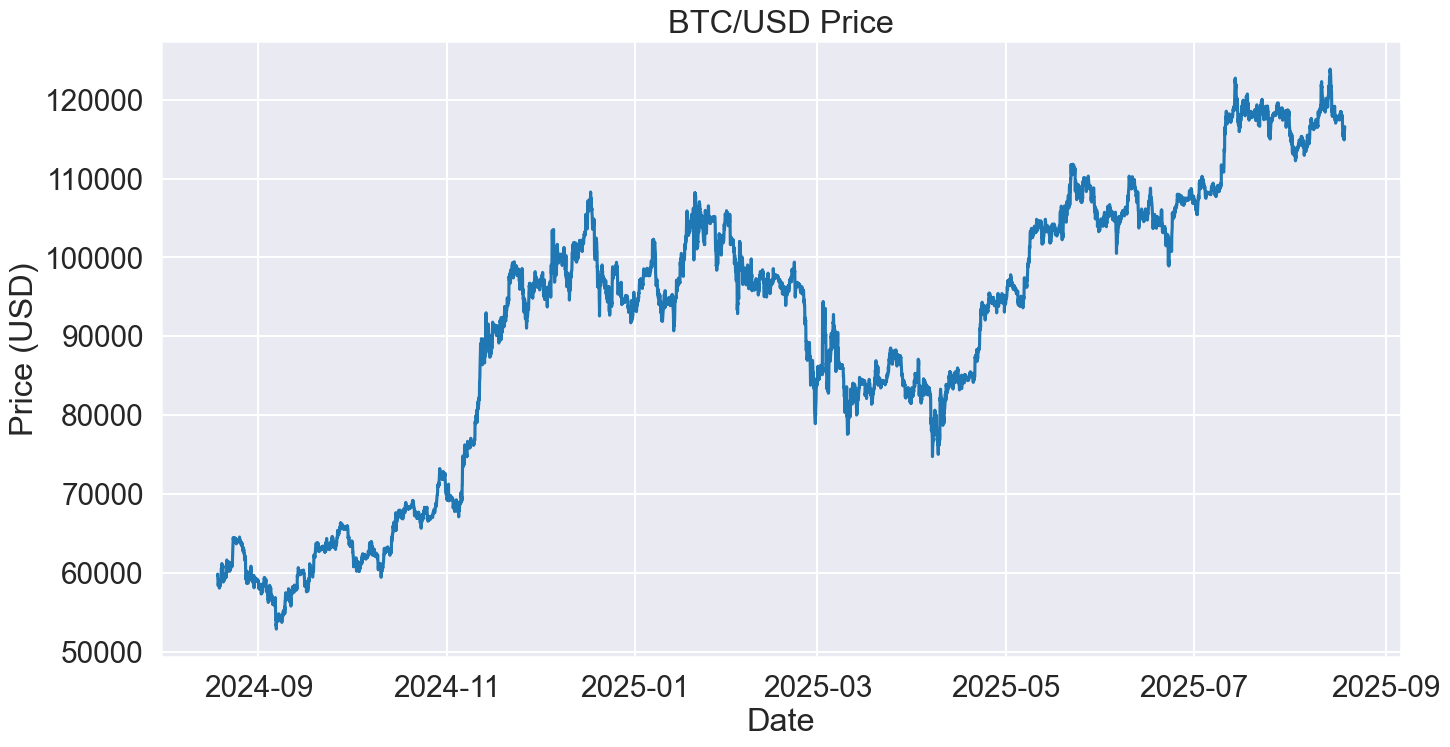

In [11]:
sns.set_context('talk', font_scale=1.3)

with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots(figsize=(16, 8))
    sns.lineplot(data=df, x=df.index, y='close', ax=ax)
    ax.set_title('BTC/USD Price')
    ax.set_ylabel('Price (USD)')
    ax.set_xlabel('Date')
    plt.show()

### Diagnostics

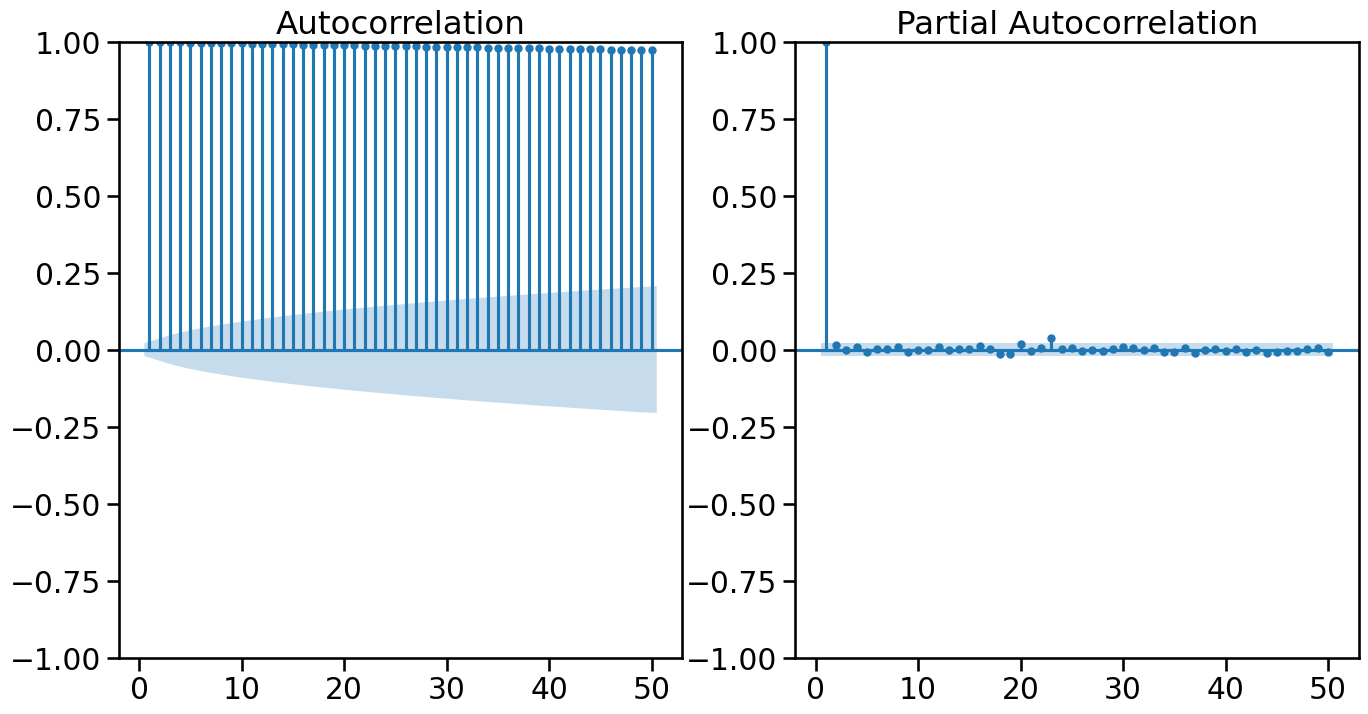

In [12]:
# acf and pacf plots
plt.rcParams['figure.figsize'] = [16, 8]
fig, axes = plt.subplots(1,2, sharex=True)
sgt.plot_acf(df['close'], lags=50, ax=axes[0], zero=False);
sgt.plot_pacf(df['close'], lags=50, ax=axes[1], zero=False);

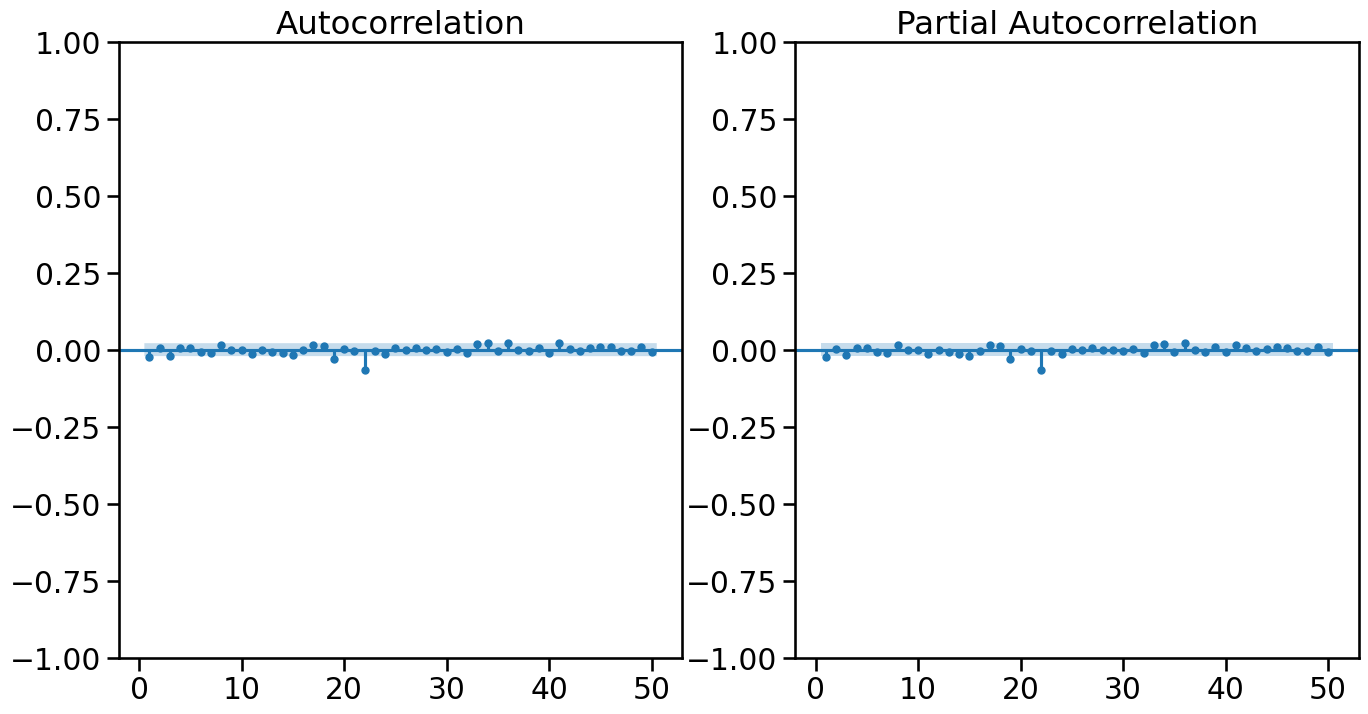

In [13]:
# differenced once
df['close_diff'] = df['close'].diff()
plt.rcParams['figure.figsize'] = [16, 8]
fig, axes = plt.subplots(1,2, sharex=True)
sgt.plot_acf(df['close_diff'].dropna(), lags=50, ax=axes[0], zero=False);
sgt.plot_pacf(df['close_diff'].dropna(), lags=50, ax=axes[1], zero=False);

In [14]:
dftest = adfuller(df['close'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])

for k, v in dftest[4].items():
    dfoutput[f'Critical Value ({k})'] = v
    
print(dfoutput)

Test Statistic                   -1.316893
p-value                           0.621409
#Lags Used                       22.000000
Number of Observations Used    8736.000000
Critical Value (1%)              -3.431099
Critical Value (5%)              -2.861871
Critical Value (10%)             -2.566946
dtype: float64


In [15]:
dftest = adfuller(df['close_diff'].dropna(), autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])

for k, v in dftest[4].items():
    dfoutput[f'Critical Value ({k})'] = v
    
print(dfoutput)

Test Statistic                  -22.265284
p-value                           0.000000
#Lags Used                       21.000000
Number of Observations Used    8736.000000
Critical Value (1%)              -3.431099
Critical Value (5%)              -2.861871
Critical Value (10%)             -2.566946
dtype: float64


In [16]:
df['returns'] = 100 * df['close'].pct_change().dropna()
df['log_returns'] = np.log(df['close'] / df['close'].shift(1)).dropna()

In [17]:
df.head()

,open,high,low,close,volume,trade_count,vwap,close_diff,returns,log_returns
timestamp,,,,,,,,,,
2024-08-18 19:00:00+00:00,59610.765,59767.50,59513.7010,59706.0415,0.000949,3.0,59695.255456,NaN,NaN,NaN
2024-08-18 20:00:00+00:00,59722.223,59859.46,59694.5135,59824.0010,0.242421,1.0,59799.191000,117.9595,0.197567,0.001974
2024-08-18 21:00:00+00:00,59820.190,59820.19,59373.1250,59456.7950,0.011050,3.0,59629.841804,-367.2060,-0.613811,-0.006157
2024-08-18 22:00:00+00:00,59493.698,59600.15,59331.1400,59378.6695,0.025719,7.0,59403.948339,-78.1255,-0.131399,-0.001315
2024-08-18 23:00:00+00:00,59317.953,59428.70,58421.2000,58436.3760,0.057852,20.0,59116.567230,-942.2935,-1.586923,-0.015996


In [18]:
df.dropna(inplace=True)

In [19]:
df['sq_returns'] = df['returns'] ** 2

Text(0.5, 1.0, 'Distribution of Squared Returns')

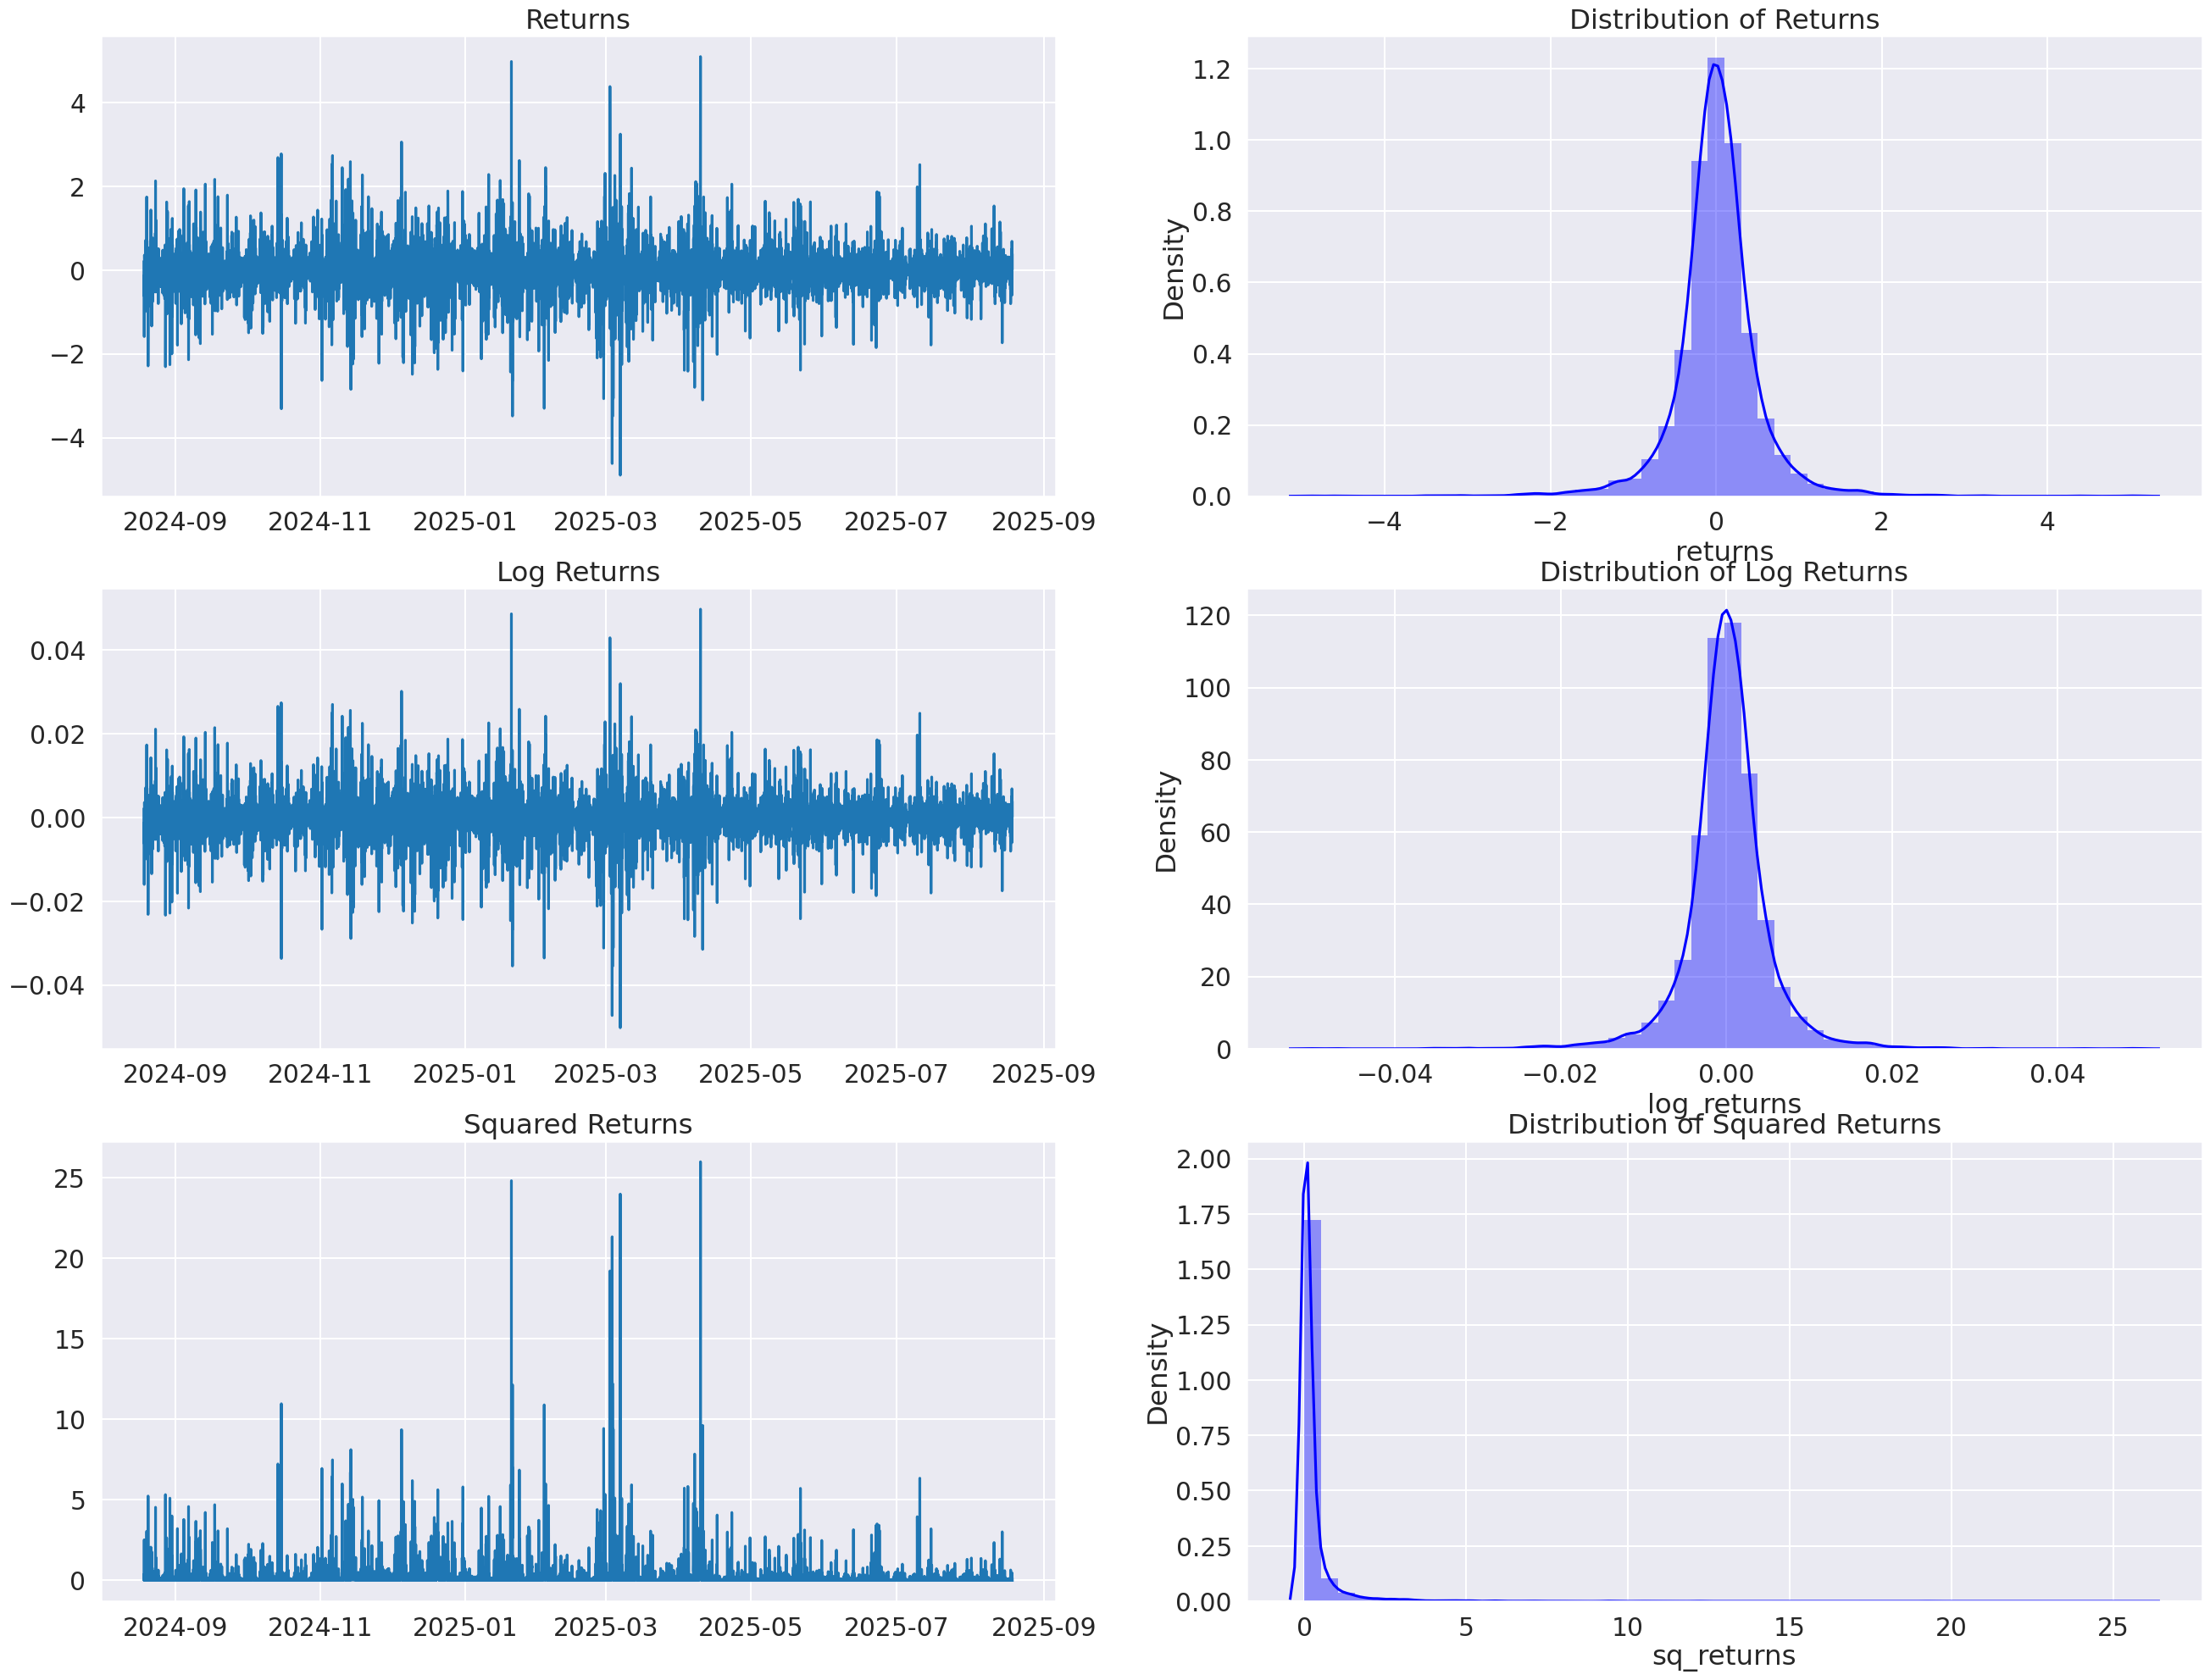

In [20]:
with sns.axes_style('darkgrid'):
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(32, 24))

axes[0, 0].plot(df['returns'], label='Returns')
axes[0, 0].set_title('Returns')

sns.distplot(df['returns'], norm_hist=True, color = 'blue', bins = 50, ax=axes[0,1])
axes[0, 1].set_title('Distribution of Returns')


axes[1, 0].plot(df['log_returns'], label='Log Returns')
axes[1, 0].set_title('Log Returns')

sns.distplot(df['log_returns'], norm_hist=True, color = 'blue', bins = 50, ax=axes[1,1])
axes[1, 1].set_title('Distribution of Log Returns')

axes[2, 0].plot(df['sq_returns'], label='Squared Returns')
axes[2, 0].set_title('Squared Returns')

sns.distplot(df['sq_returns'], norm_hist=True, color = 'blue', bins = 50, ax=axes[2,1])
axes[2, 1].set_title('Distribution of Squared Returns')


In [21]:
df['returns'].describe()

count    8758.000000
mean        0.008915
std         0.505159
min        -4.895889
25%        -0.206488
50%         0.007124
75%         0.229644
max         5.096550
Name: returns, dtype: float64

In [22]:
df['log_returns'].describe()

count    8758.000000
mean        0.000076
std         0.005053
min        -0.050198
25%        -0.002067
50%         0.000071
75%         0.002294
max         0.049709
Name: log_returns, dtype: float64

In [23]:
df['sq_returns'].describe()

count    8.758000e+03
mean     2.552359e-01
std      8.882997e-01
min      4.354094e-08
25%      1.024856e-02
50%      4.763961e-02
75%      1.750317e-01
max      2.597482e+01
Name: sq_returns, dtype: float64

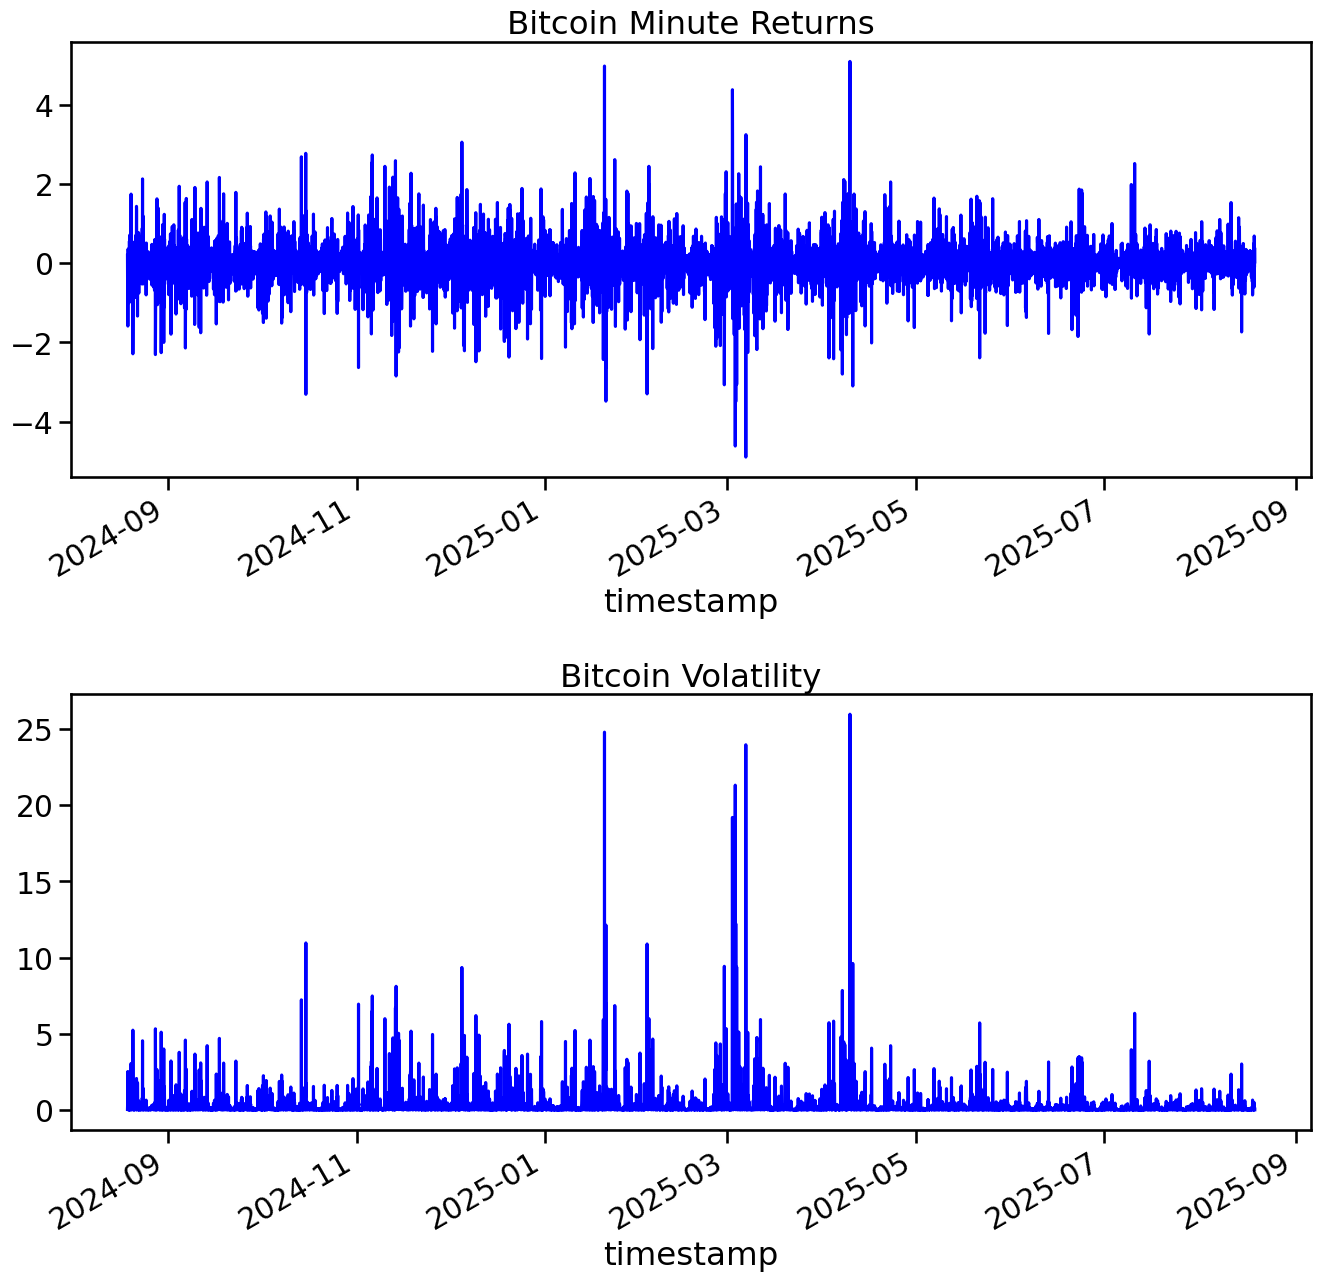

In [24]:
plt.figure(figsize=(16, 16))
plt.subplot(211)

df['returns'].plot(title='Returns', color='blue')
plt.title('Bitcoin Minute Returns')

plt.subplot(212)
df['sq_returns'].plot(title='Squared Returns', color='blue')
plt.title('Bitcoin Volatility')

plt.subplots_adjust(hspace=0.5)
plt.show()

# Garch Model

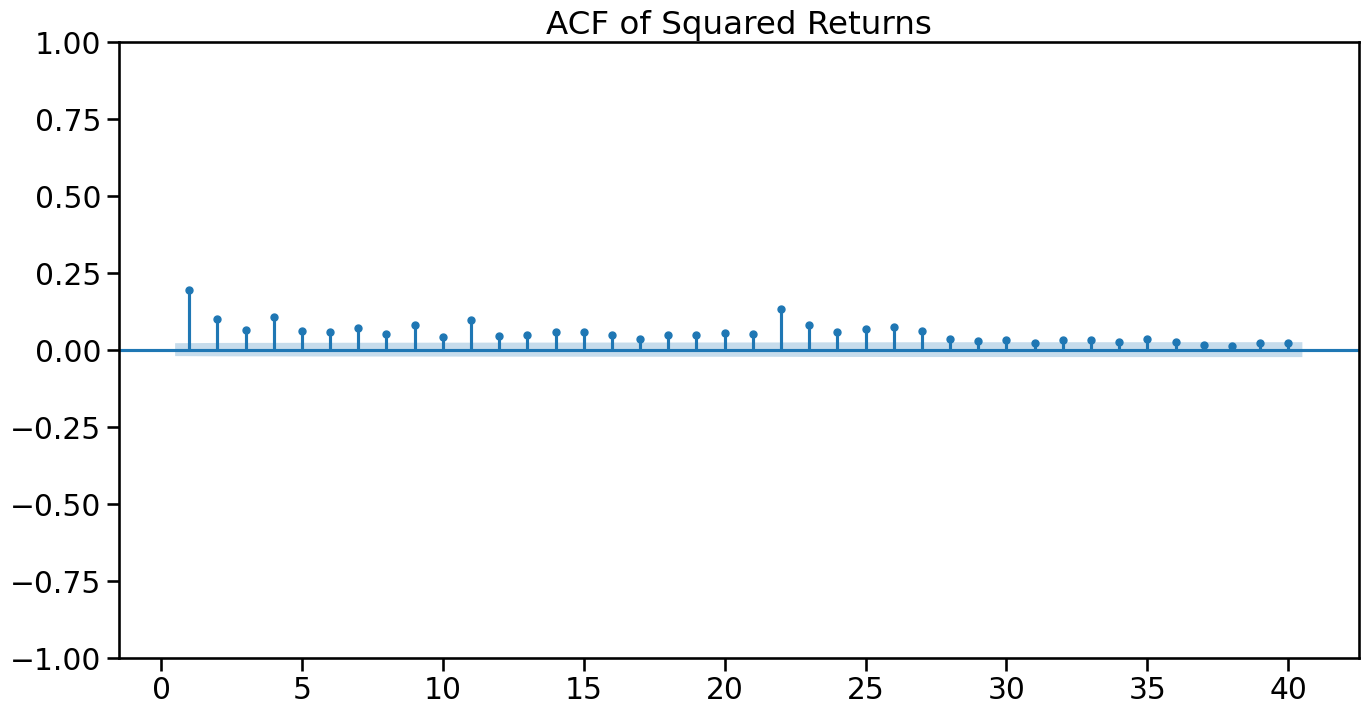

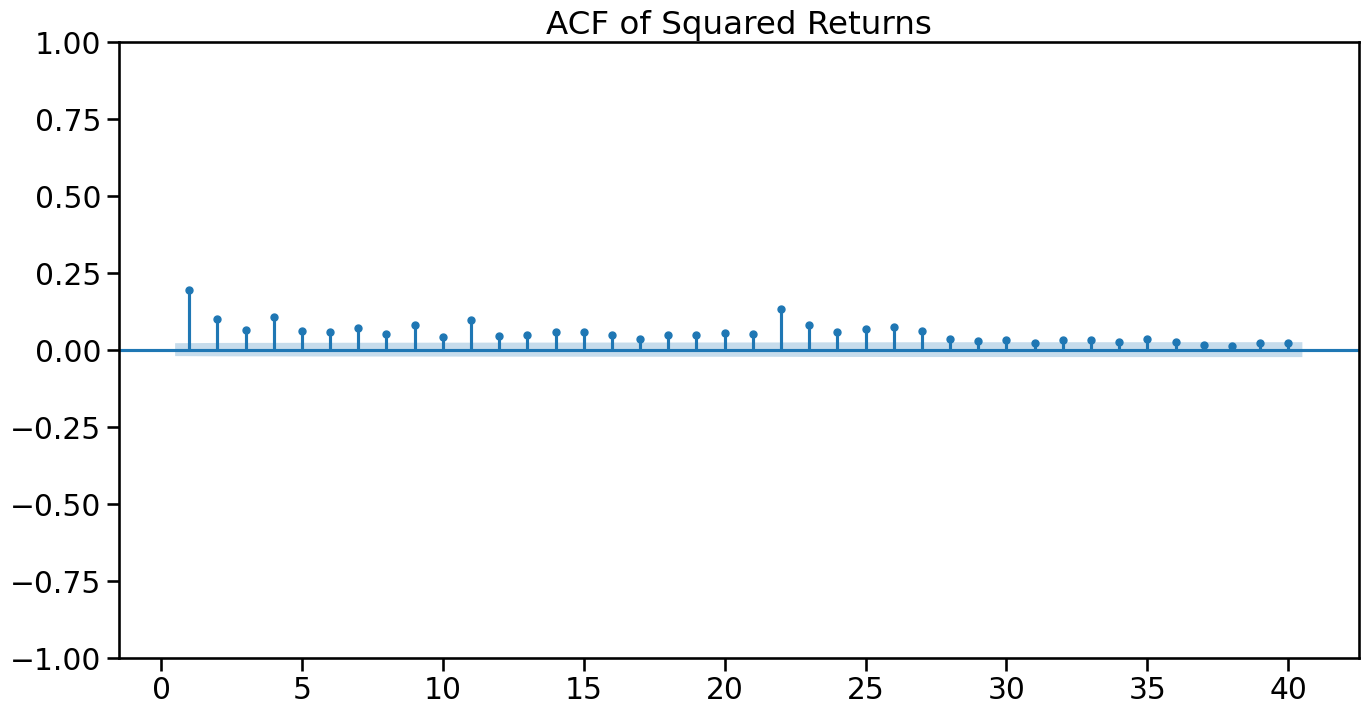

In [25]:
plot_acf(df['sq_returns'], title='ACF of Squared Returns', zero=False)

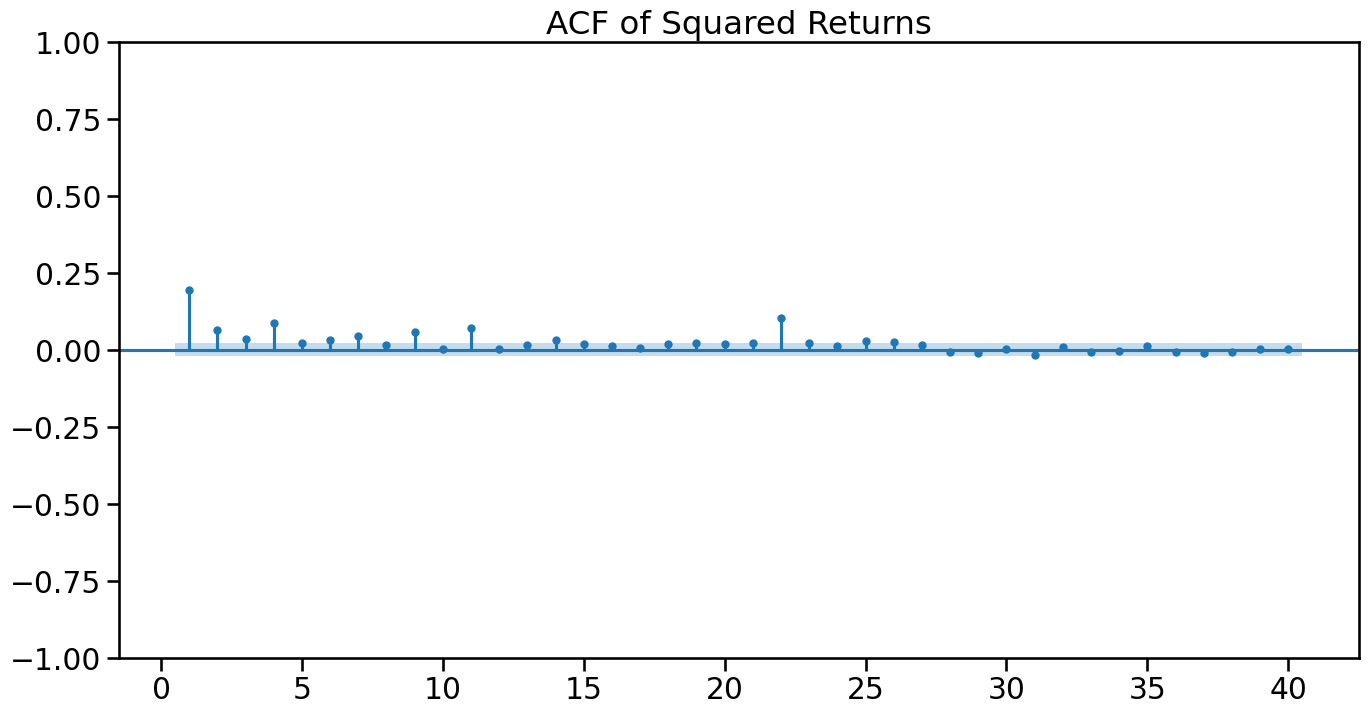

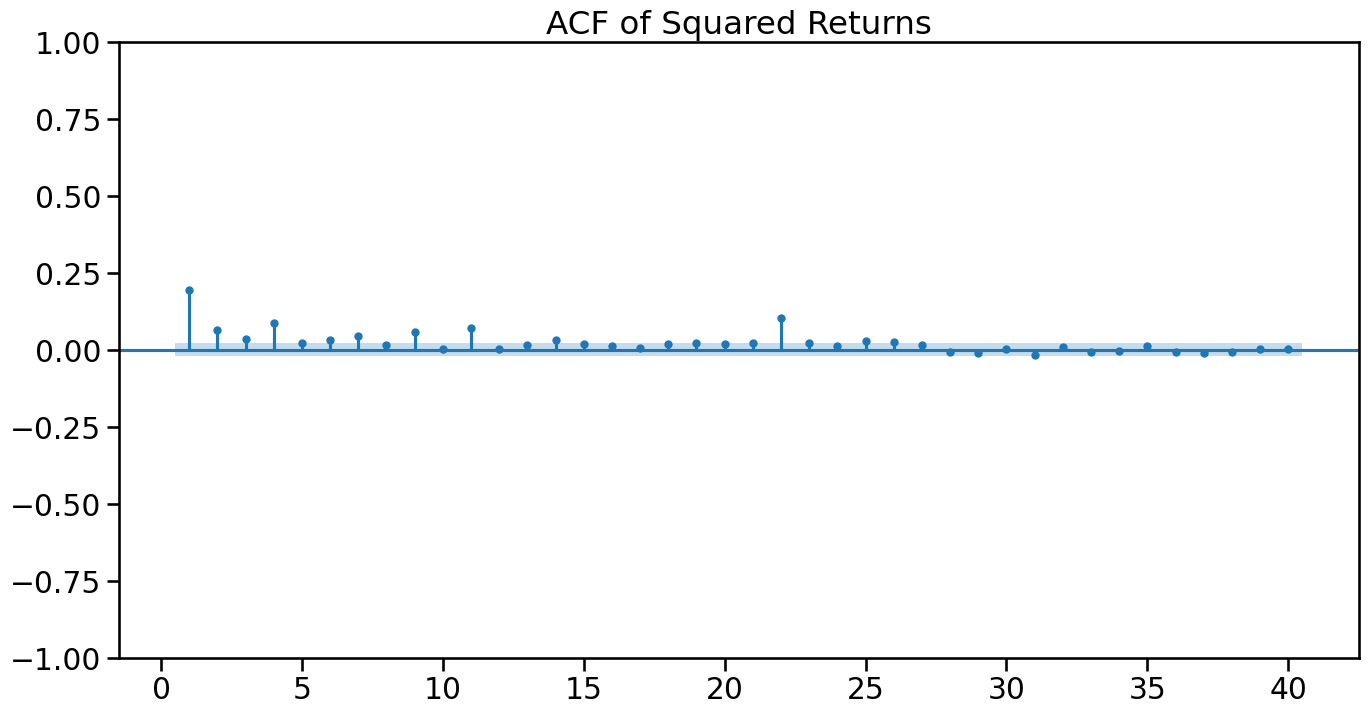

In [26]:
plot_pacf(df['sq_returns'], title='ACF of Squared Returns', zero=False)